# Knee X-ray Analysis Using ResNet for Osteoarthritis Severity Assessment

This uses pre-trained ResNet-18 model, to analyze and assess the severity of knee X-ray images in Osteoarthritis Initiative (OAI) dataset.

### References
**This data is collected from:**
1. Chen, Pingjun (2018), “Knee Osteoarthritis Severity Grading Dataset”, Mendeley Data, V1, doi: 10.17632/56rmx5bjcr.1 
**This code is referenced from:**
1. Bernard Adhitya Kurniawan https://www.kaggle.com/code/bernardadhitya/knee-x-ray-analysis-with-resnet-for-osteoarthritis

### Resources
**Other trials:**
- Muhammad Faizan for data preprocessing https://www.kaggle.com/code/muhammadfaizan65/knee-arthritis-detection-using-efficientnetb0

### Extra Notes:
**Focus on high false positive:**
- low precision + high recall / fair F1-score
- predict more healthy people as sick
[!!!Tips: Look at accuracy, if you only have one model. Look at confusion matrix/other metrics, if you have more than one model]


## Step 1: Import Libraries
First, we need to import the necessary libraries for data handling, model building, training, and evaluation.

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, utils

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tqdm import tqdm


## Step 2: Load and Prepare the Dataset
We will create the function `load_dataset_as_dataframe()` to load the OAI dataset from the subdirectories prepared for us; `train/` and `test/`, and organize the image paths and labels.

- We traverse through each class folder (representing osteoarthritis severity grades; `['0', '1', '2', '3', '4']`) and collect image paths and corresponding labels.
- The classes list contains all the class names, and class_to_idx maps these class names to numeric labels.
- We create a DataFrame data for easier data manipulation.

In [ ]:
def load_dataset_as_dataframe(subdir):
    # Define the path to the dataset
    data_dir = f"Training\{subdir}"

    # Create lists to store image paths and labels
    image_paths = []
    labels = []

    # Get the list of class directories
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    classes.sort()
    print('Classes:', classes)

    # Map class names to labels
    class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}

    # Loop over each class directory
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        label = class_to_idx[class_name]
        # Get all image files in the class directory
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if os.path.isfile(img_path):
                image_paths.append(img_path)
                labels.append(label)

    # Create a DataFrame
    data = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })
    
    # Show the distribution of labels in the dataset
    dataset_distribution_dict = {}
    for i in range(5):
        dataset_distribution_dict[i] = len(data[data['label'] == i])
    print(dataset_distribution_dict)
    print()

    return data

## Step 3: Split the Dataset
Using the above function `load_dataset_as_dataframe()`, we'll load the test and train dataset as dataframe

In [6]:
# Prepare training and test dataset as dataframes
classes = ['0', '1', '2', '3', '4']
train_df = load_dataset_as_dataframe('train')
test_df = load_dataset_as_dataframe('test')

print(train_df.count)
print(test_df.head(10))

Classes: ['0', '1', '2', '3', '4']
{0: 411, 1: 381, 2: 185, 3: 176, 4: 164}

Classes: ['0', '1', '2', '3', '4']
{0: 103, 1: 96, 2: 47, 3: 45, 4: 42}

<bound method DataFrame.count of                                image_path  label
0       Training\train\0\NormalG0 (1).png      0
1      Training\train\0\NormalG0 (10).png      0
2     Training\train\0\NormalG0 (100).png      0
3     Training\train\0\NormalG0 (101).png      0
4     Training\train\0\NormalG0 (102).png      0
...                                   ...    ...
1312   Training\train\4\SevereG4 (95).png      4
1313   Training\train\4\SevereG4 (96).png      4
1314   Training\train\4\SevereG4 (97).png      4
1315   Training\train\4\SevereG4 (98).png      4
1316   Training\train\4\SevereG4 (99).png      4

[1317 rows x 2 columns]>
                           image_path  label
0  Training\test\0\NormalG0 (106).png      0
1  Training\test\0\NormalG0 (109).png      0
2  Training\test\0\NormalG0 (113).png      0
3  Training\test\0\Norm

## Step 4: Define Image Transformations
We define transformations for data augmentation and normalization.

* Images are resized to 224x224 pixels to match the input size expected by ResNet.
* Data augmentation is applied to the training set with random horizontal flips.
* Images are normalized using ImageNet mean and standard deviation values.

In [7]:
# Define image transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet standards
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


## Step 5: Create Custom Dataset Class
We create a custom dataset class to handle image loading and preprocessing.

* The `KneeDataset` class inherits from torch.utils.data.Dataset.
* The `__getitem__` method loads and returns an image and its label.

In [8]:
# Create custom dataset class
class KneeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'image_path']
        label = self.df.loc[idx, 'label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


## Step 6: Create DataLoaders
We create DataLoader objects for batching and shuffling the data.

* `batch_size=32` specifies the number of samples per batch.
* `shuffle=True` randomizes the order of data every epoch in the training set.

In [9]:
# Create dataset instances
train_dataset = KneeDataset(train_df, transform=train_transform)
test_dataset = KneeDataset(test_df, transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


## Step 7: Visualize Sample Images
We can visualize a batch of training images to verify the data loading and transformations.

* We define an `imshow` function to display images after unnormalizing them.
* We use `utils.make_grid` to create a grid of images.

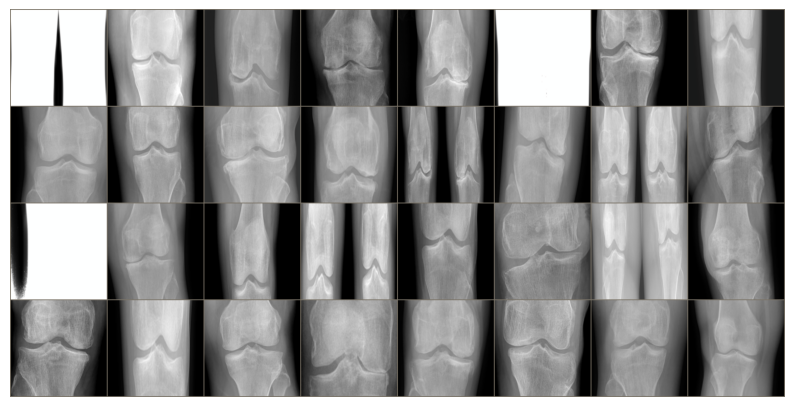

In [10]:
# Function to display images
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    # Unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img  = std * img + mean
    img  = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

# Get a batch of training data
images, labels = next(iter(train_loader))

# Make a grid from batch
out = utils.make_grid(images)

# Display images
plt.figure(figsize=(10, 10))
imshow(out)
plt.show()


## Step 8: Load and Modify the Pre-trained ResNet Model
We load a pre-trained ResNet18 model and modify the final layer to match our number of classes.

* We replace the final fully connected layer (`model.fc`) to output the correct number of classes for our dataset.
* `pretrained=True` loads weights trained on ImageNet.

In [12]:
# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the final layer
model.fc = nn.Linear(model.fc.in_features, 5)



## Step 9: Define Loss Function and Optimizer
We set up the loss function and optimizer for training.

* `CrossEntropyLoss` is suitable for multi-class classification.
* `Adam` optimizer is used with a learning rate of 0.001.

In [13]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


## Step 10: Train the Model
We train the model for a few epochs.

* We iterate over the training data, compute the loss, perform backpropagation, and update the model weights.
* `model.train()` sets the model to training mode.

In [76]:
# Number of epochs
num_epochs = 25

# Training loop with progress bars
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    # Wrap the train_loader with tqdm for a progress bar
    pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Update running loss
        running_loss += loss.item() * images.size(0)
        
        # Calculate accuracy within the batch
        _, preds = torch.max(outputs, 1)
        total_correct += torch.sum(preds == labels.data)
        total_samples += labels.size(0)
        
        # Update progress bar description
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{(total_correct/total_samples*100):.2f}%'
        })
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = total_correct.double() / len(train_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

Epoch [1/25]:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch [1/25]: 100%|██████████| 42/42 [05:03<00:00,  7.23s/it, loss=0.5450, acc=54.75%]


Epoch [1/25], Loss: 1.1622, Accuracy: 0.5475


Epoch [2/25]: 100%|██████████| 42/42 [04:54<00:00,  7.02s/it, loss=0.9399, acc=65.98%]


Epoch [2/25], Loss: 0.8144, Accuracy: 0.6598


Epoch [3/25]: 100%|██████████| 42/42 [04:57<00:00,  7.08s/it, loss=1.2151, acc=70.24%]


Epoch [3/25], Loss: 0.7316, Accuracy: 0.7024


Epoch [4/25]: 100%|██████████| 42/42 [05:11<00:00,  7.43s/it, loss=0.9706, acc=71.60%]


Epoch [4/25], Loss: 0.7163, Accuracy: 0.7160


Epoch [5/25]: 100%|██████████| 42/42 [05:21<00:00,  7.66s/it, loss=0.4514, acc=75.63%]


Epoch [5/25], Loss: 0.6106, Accuracy: 0.7563


Epoch [6/25]: 100%|██████████| 42/42 [04:40<00:00,  6.69s/it, loss=0.3009, acc=77.60%]


Epoch [6/25], Loss: 0.5589, Accuracy: 0.7760


Epoch [7/25]: 100%|██████████| 42/42 [04:47<00:00,  6.85s/it, loss=1.2814, acc=79.80%]


Epoch [7/25], Loss: 0.5228, Accuracy: 0.7980


Epoch [8/25]: 100%|██████████| 42/42 [04:43<00:00,  6.74s/it, loss=1.3045, acc=81.55%]


Epoch [8/25], Loss: 0.4893, Accuracy: 0.8155


Epoch [9/25]: 100%|██████████| 42/42 [04:43<00:00,  6.76s/it, loss=1.5705, acc=77.68%]


Epoch [9/25], Loss: 0.5616, Accuracy: 0.7768


Epoch [10/25]: 100%|██████████| 42/42 [04:42<00:00,  6.73s/it, loss=0.0503, acc=81.55%]


Epoch [10/25], Loss: 0.4977, Accuracy: 0.8155


Epoch [11/25]: 100%|██████████| 42/42 [04:44<00:00,  6.77s/it, loss=1.5079, acc=84.89%]


Epoch [11/25], Loss: 0.4029, Accuracy: 0.8489


Epoch [12/25]: 100%|██████████| 42/42 [04:40<00:00,  6.69s/it, loss=0.3043, acc=81.09%]


Epoch [12/25], Loss: 0.5074, Accuracy: 0.8109


Epoch [13/25]: 100%|██████████| 42/42 [04:36<00:00,  6.59s/it, loss=0.3747, acc=90.28%]


Epoch [13/25], Loss: 0.2708, Accuracy: 0.9028


Epoch [14/25]: 100%|██████████| 42/42 [04:38<00:00,  6.63s/it, loss=0.0973, acc=87.93%]


Epoch [14/25], Loss: 0.3090, Accuracy: 0.8793


Epoch [15/25]: 100%|██████████| 42/42 [04:42<00:00,  6.72s/it, loss=0.0337, acc=90.51%]


Epoch [15/25], Loss: 0.2560, Accuracy: 0.9051


Epoch [16/25]: 100%|██████████| 42/42 [04:38<00:00,  6.62s/it, loss=0.5362, acc=91.72%]


Epoch [16/25], Loss: 0.2199, Accuracy: 0.9172


Epoch [17/25]: 100%|██████████| 42/42 [04:41<00:00,  6.71s/it, loss=0.4346, acc=91.57%]


Epoch [17/25], Loss: 0.2140, Accuracy: 0.9157


Epoch [18/25]: 100%|██████████| 42/42 [04:26<00:00,  6.34s/it, loss=0.6276, acc=86.03%]


Epoch [18/25], Loss: 0.3703, Accuracy: 0.8603


Epoch [19/25]: 100%|██████████| 42/42 [04:49<00:00,  6.90s/it, loss=2.1377, acc=87.02%]


Epoch [19/25], Loss: 0.3533, Accuracy: 0.8702


Epoch [20/25]: 100%|██████████| 42/42 [04:58<00:00,  7.12s/it, loss=0.2773, acc=88.08%]


Epoch [20/25], Loss: 0.3092, Accuracy: 0.8808


Epoch [21/25]: 100%|██████████| 42/42 [04:37<00:00,  6.61s/it, loss=0.2425, acc=93.17%]


Epoch [21/25], Loss: 0.1914, Accuracy: 0.9317


Epoch [22/25]: 100%|██████████| 42/42 [04:41<00:00,  6.70s/it, loss=2.4110, acc=91.65%]


Epoch [22/25], Loss: 0.2215, Accuracy: 0.9165


Epoch [23/25]: 100%|██████████| 42/42 [04:18<00:00,  6.15s/it, loss=0.1480, acc=90.51%]


Epoch [23/25], Loss: 0.2566, Accuracy: 0.9051


Epoch [24/25]: 100%|██████████| 42/42 [04:01<00:00,  5.75s/it, loss=1.7478, acc=94.15%]


Epoch [24/25], Loss: 0.1644, Accuracy: 0.9415


Epoch [25/25]: 100%|██████████| 42/42 [04:00<00:00,  5.72s/it, loss=1.3660, acc=90.51%]

Epoch [25/25], Loss: 0.2888, Accuracy: 0.9051


## Step 11: Evaluate the Model
We test the model on the test set and evaluate its performance.

* `model.eval()` sets the model to evaluation mode.
* We disable gradient computation with `torch.no_grad()`.
* We collect all predictions and true labels to compute accuracy and generate reports.
* The confusion matrix and classification report provide detailed insights into model performance.

Accuracy on test set: 0.7417
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.65      0.74       103
           1       0.71      0.78      0.75        96
           2       0.60      0.72      0.65        47
           3       0.85      0.78      0.81        45
           4       0.68      0.86      0.76        42

    accuracy                           0.74       333
   macro avg       0.74      0.76      0.74       333
weighted avg       0.76      0.74      0.74       333

Confusion Matrix:
[[67 24 11  1  0]
 [ 7 75  7  1  6]
 [ 1  3 34  3  6]
 [ 2  0  3 35  5]
 [ 0  3  2  1 36]]


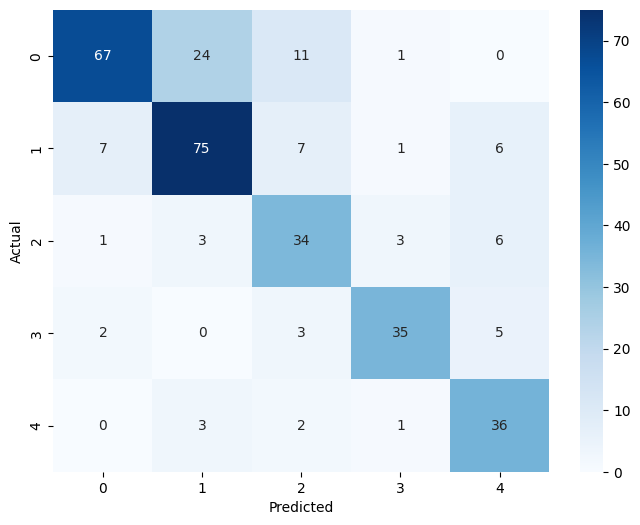

In [ ]:
# Evaluate the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy on test set: {accuracy:.4f}')

# Classification report
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [ ]:
# save the trained model
torch.save({
    'epoch': epoch,
    'model': model,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'checkpoint.pth')

## Step 12 (Optional): Load the model and see if it works


C:\Users\Wong Hui Ying\AppData\Local\Temp\ipykernel_16080\2550503602.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_checkpoint_path)


              precision    recall  f1-score   support

           0       0.87      0.65      0.74       103
           1       0.71      0.78      0.75        96
           2       0.60      0.72      0.65        47
           3       0.85      0.78      0.81        45
           4       0.68      0.86      0.76        42

    accuracy                           0.74       333
   macro avg       0.74      0.76      0.74       333
weighted avg       0.76      0.74      0.74       333

Confusion Matrix:
[[67 24 11  1  0]
 [ 7 75  7  1  6]
 [ 1  3 34  3  6]
 [ 2  0  3 35  5]
 [ 0  3  2  1 36]]


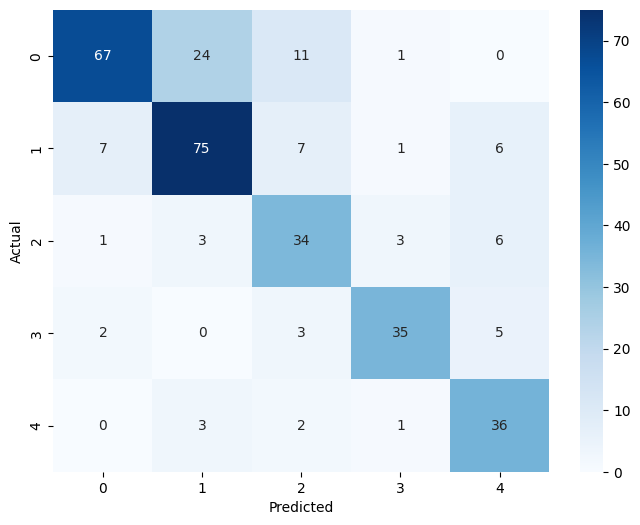

In [14]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize


# Load your model (modify if necessary based on your model architecture)
def load_model(model_checkpoint_path):
    # Load the model's state_dict (weights)
    model = models.resnet18(pretrained=True)
    # Modify the final fully connected layer
    model.fc = torch.nn.Linear(model.fc.in_features, 5)
    checkpoint = torch.load(model_checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    return model

model = load_model("checkpoint.pth") 
# Set the model to evaluation mode
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    # including precision, recall, F1-score, and support for each class
    print(classification_report(all_labels, all_preds, target_names=classes))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print('Confusion Matrix:')
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

## Step 13: Build a interface for the knee x-ray detection model


In [15]:
import gradio as gr


# Function to predict the image and get confidence score
def predict_image(image, model):
    image = test_transform(image).unsqueeze(0)
    image = image.to(device)
    model = model.to(device)

    # Get model's prediction and confidence scores
    with torch.no_grad():
        outputs = model(image)
        probs = torch.softmax(outputs, dim=1)  # Get class probabilities
        confidence, predicted_class = torch.max(probs, 1)  # Get the highest probability and corresponding class
    
    confidence_score = confidence.item() * 100  # Convert to percentage
    predicted_class = predicted_class.item()
    
    return predicted_class, confidence_score

# Gradio Interface function
def inference(image, model):
    predicted_class, confidence_score = predict_image(image, model)
    return f"Predicted Class: {predicted_class}, Confidence: {confidence_score:.2f}%"

# Create Gradio Interface
def create_interface():
    # Interface for uploading the model and predicting
    def upload_and_predict(image):
        model = load_model("checkpoint.pth") 
        print(inference(image, model))
        return inference(image, model)

    interface = gr.Interface(
        fn=upload_and_predict,
        inputs=gr.Image(type="pil", label="Upload Image for Prediction"),
        outputs="text",
        live=True
    )

    return interface



# Launch Gradio app
if __name__ == "__main__":
    interface = create_interface()
    interface.launch()

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


c:\Users\Wong Hui Ying\Documents\ML\KneeOA\venv-3.12\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Wong Hui Ying\Documents\ML\KneeOA\venv-3.12\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Wong Hui Ying\AppData\Local\Temp\ipykernel_16080\2550503602.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during un

Predicted Class: 1, Confidence: 53.56%
